#### MNIST Handwritten Digits Recognition

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib as mpl
import threading
import pickle
import joblib
import copy
import threading
from sklearn import impute, preprocessing, model_selection, base, metrics, linear_model, pipeline, ensemble, svm, multiclass, neighbors, compose, datasets, decomposition, manifold, tree
import tensorflow as tf
from tensorflow import keras
import cv2
from scratch_models import my_decorators

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

Let us have a peek at the data.

In [27]:
# List the first item of each class
def list_distinct(X, y):
    distinct_items = []
    for i in range(10):
        distinct_items.append(X[y==i][0])
    return distinct_items

In [28]:
# Plot all distinct images
def plot_grid(items, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2))
    for item, class_, axis in zip(items, range(0,10), axes.flat):
        axis.imshow(item, cmap='binary')
        axis.set_title(class_)
        axis.axis('off')

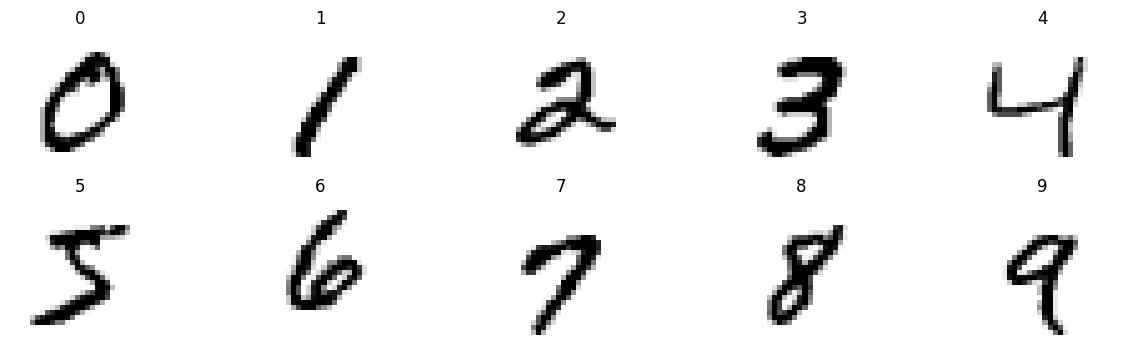

In [29]:
plot_grid(list_distinct(X_train, y_train))

In [7]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

I had created a custom decorator in ``my_decorators`` module of this repo, to convert functions into sklearn FunctionTransformers, because I like working cleanly and writing Pipeline friendly code and creating custom transformers for small tasks might be an overkill.

There isn't much scope of pre-processing, the data looks quite clean enough. I will, hence, be applying the following transformations only before moving to training phase:
* Flattening
* Normalization
* Visualizations

In [5]:
# Define the function to flatten images
@my_decorators.sklearn_transformer
def Flatten(X, y=None):
    n = X.shape[0]
    b = X.shape[1:]
    return X.reshape(n, np.prod(b))

In [153]:
# Initial pipeline for flattening and normalization
pre_pipeline = pipeline.Pipeline([('flatten', Flatten),
                                  ('scaler', preprocessing.StandardScaler())])

In [154]:
X_prep = pre_pipeline.fit_transform(X_train)

In [145]:
X_prep.shape, X_prep.max()

((60000, 784), 1.0)

**Visualizations**

Let us use **tSNE** to project the data down to 2 dimensions. The following code compresses the training images into 2 dimensions which preserve the highest information content. I have used **Barnes-Hut t-SNE**. It converges in O(n*log(n)) and since we have 60000 example images, Exact t-SNE might not be the optimal choice.
While plotting, I have only used first 4000 images for interpretability.

In [158]:
tsne = manifold.TSNE(n_components=2, random_state=42, method='barnes_hut') 

X_viz = tsne.fit_transform(X_prep)

In [170]:
def plot_digits(X, y, min_distance=0.04, n_points=4000, images=None, figsize=(13, 10)):
    
    # Shape compatibility and normalization
    X, y = X[:n_points], y[:n_points]
    X = preprocessing.MinMaxScaler().fit_transform(X)
    
    
    # This array stores all the plotted digit images (plus a faraway point to begin with)
    neighbors = np.array([[10., 10.]])
    
    # Scatter plot all points
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X[y == digit, 0], X[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    
    # Plot actual digits
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is not None:
                images = images[:n_points]
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary", zoom=0.4),
                                          image_coord)
                ax.add_artist(imagebox)

In [ ]:
plot_digits(X_viz, y_train, figsize=(5,4))

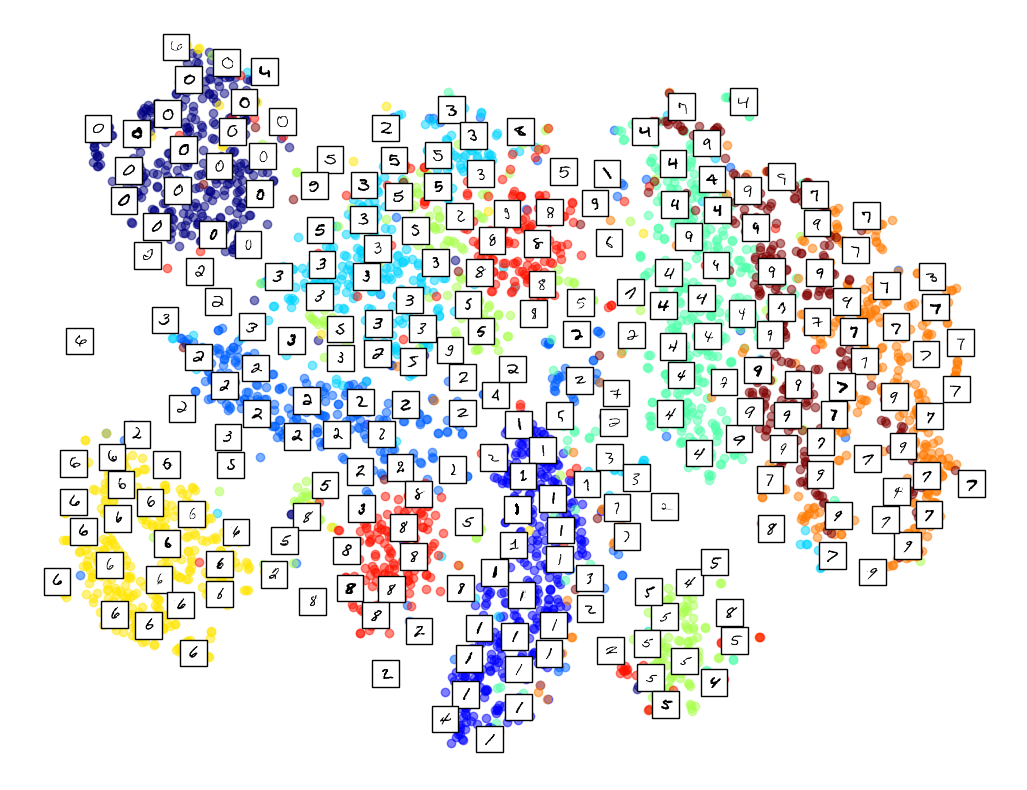

In [166]:
plot_digits(X_viz, y_train, images=X_train)

<i>Images in the images directory might be slightly different, due to multiple runs</i>
A quick glance reveals that digits 3, 5 and 8 are quite close. Some of the 8s are so isolated from major clusters as well. Hence, I can expect my model making frequent for these digits. If that happens to be the case, I shall resort to grabbing more training data for these digits or engineering features to make the loops stand out.

One last thing to look at, Principal Components. Looking at the images, it is clear that most of the pixel values (especially at the boundaries) in every image are 0s (plain white pixels). Hence, I doubt, even a small subset of features can explain major proportion of variance.

In [167]:
pca = decomposition.PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_prep)

X_pca.shape

(60000, 331)

Clearly, only 331 of 784 features are able to explain 95% of variance. I might get pretty good accuracy slightly faster if I use these features instead of all. However, I am more after accuracy than speed, hence I'll be using full set of features.

**Final Pipeline**

In [6]:
prep_pipe = pipeline.Pipeline([('flatten', Flatten),
                               ('scaler', preprocessing.StandardScaler())])

X_train_prep = prep_pipe.fit_transform(X_train)
X_test_prep = prep_pipe.transform(X_test)

**Training**

In [183]:
distinct = {}

for label in np.unique(y_train):
    distinct.update({label:np.count_nonzero(y_train==label)/len(y_train)})

distinct

{0: 0.09871666666666666,
 1: 0.11236666666666667,
 2: 0.0993,
 3: 0.10218333333333333,
 4: 0.09736666666666667,
 5: 0.09035,
 6: 0.09863333333333334,
 7: 0.10441666666666667,
 8: 0.09751666666666667,
 9: 0.09915}

The dataset looks quite balanced, hence I am choosing **accuracy score** as my primary performace metric. Let us start training with few of the most viable algorithms for such tasks. I am training some popular models - Decision Trees, Linear SVM, Softmax, Random Forest and SGD Classifier. SGD classifier might not be a good choice because it doesn't scale very well with the number of examples, 60K in our case. Same is the case with SVM, but since we have a lot of sparse features, SVMs might perform good. I still wanna try out SGD too, though.

In [193]:
dt_clf = tree.DecisionTreeClassifier()  # Decision Tree (zero expectations from this lol)
lin_svc = svm.LinearSVC()               # Linear SVM Classifier
sfmx_clf = linear_model.LogisticRegression(multi_class='multinomial')    # Softmax Regression
rf_clf = ensemble.RandomForestClassifier()                      # Random Forest Classifier with 100 trees
sgd_clf = linear_model.SGDClassifier()                          # SGD Classifier

shortlist = [dt_clf, lin_svc, sfmx_clf, rf_clf, sgd_clf]

In [196]:
initial_run_scores = {}

for model in shortlist:
    score = model_selection.cross_val_score(model, X_train_prep, y_train, cv=3, n_jobs=-1)
    initial_run_scores.update({model: score.mean()})
    print(model, score)
    

DecisionTreeClassifier() [0.8552  0.85965 0.86235]
LinearSVC() [0.89885 0.90065 0.9033 ]
LogisticRegression(multi_class='multinomial') [0.90595 0.9081  0.91005]
RandomForestClassifier() [0.96405 0.9635  0.96675]
SGDClassifier() [0.90145 0.89365 0.904  ]


Pretty impressive how an un-tuned Random Forest Classifier with 100 trees achieves a validation accuracy of around 96%. I straight reject SGDClassifier, the scores are not the best, plus it's computational complexity for this task is a headache. I also reject DecisionTreeClassifier, which a no-brainer looking at the scores. Before deciding on a model, let me also give a shot to **kernel SVC** - large number of features and most of them sparse - SVM's favorite conditions.

Having said that, the Random Forest Classifier can be used for taking a look at feature importances.

**Feature Importances**

In [ ]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=50)
rf_clf.fit(X_train_prep, y_train)

Text(0.5, 1.0, 'Feature Importances')

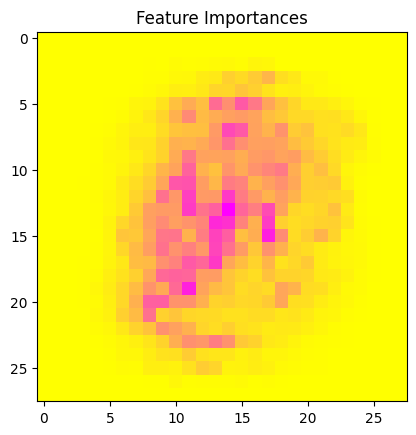

In [41]:
feature_imp_matrix = rf_clf.feature_importances_.reshape(28,28)
plt.imshow(feature_imp_matrix, cmap='spring_r')
plt.title('Feature Importances')

As is obvious, the most important and decisive pixels lie at the center(pink), the yellow pixels near boundaries have little importance in predictions; remember that our PCA also revealed a similar insight. The boundaries may be dropped for faster training and prediction without significant decay in scores. Let us stick with full features for now.

In [6]:
svc = svm.SVC()
score_svm = model_selection.cross_val_score(svc, X_train_prep, y_train, cv=3, n_jobs=-1)

score_svm.mean()

0.9602666666666666

Okay, so **RBF SVM Classifier** perform just on par with Random Forest. Instead of using RFs standalone, I have decided to fine-tune this SVC. Finally, I also plan to feed this tuned SVC to a BaggingClassifier just to see how it performs since I have enough time and resources. Ensembling this model, though, might be a case of diminishing returns; but what's wrong in trying.

In [8]:
search_space = [{'C': [0.1, 1, 10],
                 'kernel':['rbf']},
                {'C':[0.1, 1, 10],
                 'kernel':['poly'],
                 'degree':[2,3,4],
                 'coef0':[0.0, 0.2]}]

grid_search = model_selection.GridSearchCV(svc, search_space, cv=5, n_jobs=-1, scoring='accuracy', verbose=4)

In [9]:
grid_search.fit(X_train_prep, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10], 'coef0': [0.0, 0.2],
                          'kernel': ['poly']}],
             scoring='accuracy', verbose=4)

In [15]:
grid_search.best_params_, grid_search.best_score_

({'C': 10, 'coef0': 0.2, 'kernel': 'poly'}, 0.9782833333333334)

Almost 98% mean validation score! Nice. Score can be improved even further but due to computing power limitation, I'll stick with these parameters. Last thing I am going to do is feed 10 such **SVC(C=10, coef0=0.2, kernel=poly, degree=3)** classifiers to a Bagging Classifier.

In [21]:
svm_final = svm.SVC(**grid_search.best_params_)

bag_clf = ensemble.BaggingClassifier(estimator=svm_final, n_estimators=10, warm_start=True, n_jobs=-1, random_state=42)

In [22]:
bag_clf.fit(X_train_prep, y_train)

BaggingClassifier(estimator=SVC(C=10, coef0=0.2, kernel='poly'), n_jobs=-1,
                  random_state=42, warm_start=True)

In [42]:
bag_clf.score(X_test_prep, y_test)

0.9811

The BaggingClassifier with 10 SVMs lives upto the hype : **98.11 % accuracy** on the test set!


Kartik Kumar
For more projects, please visit [My GithHub Page](https://github.com/ryuukkk)